In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("zadorlab/neural-tangent-ensemble")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

summary_df = pd.json_normalize(summary_list)

# Flatten the 'config' column
config_df = pd.json_normalize(config_list)

# Concatenate the flattened DataFrames along with the 'name' column
runs_df = pd.concat([summary_df, config_df], axis=1)
runs_df.head()

,_timestamp,num_params,step,_step,epoch,_runtime,test metrics.loss_1,test metrics.loss_2,test metrics.loss_3,test metrics.loss_4,...,logger.tags,optimizer.seed,optimizer.epsilon,optimizer.max_delta,optimizer.noise_scale,optimizer.inv_temperature,optimizer.b1,optimizer.b2,optimizer.eps,model.features
0,1.714578e+09,8070.0,3749.0,46.0,45.0,390.857461,1.558443,0.692252,0.591424,0.244131,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.714577e+09,107960010.0,468.0,50.0,49.0,270.022058,0.169122,0.151833,0.104957,0.067874,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.714575e+09,12515206.0,468.0,50.0,49.0,80.945286,0.305253,0.170620,0.173578,0.082952,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.714575e+09,1796010.0,468.0,50.0,49.0,81.232067,0.300315,0.261353,0.170504,0.088920,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.714575e+09,351402.0,468.0,50.0,49.0,83.958216,0.408676,0.281910,0.247886,0.095201,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
# add number of parameters
runs_df['num_params'] = runs_df['model.features_per_layer'] * 785 + \
                        runs_df['model.features_per_layer'] * (runs_df['model.features_per_layer'] + 1) * (runs_df['model.nlayers'] - 1)\
                      + runs_df['model.nclasses'] * (runs_df['model.features_per_layer'] + 1)

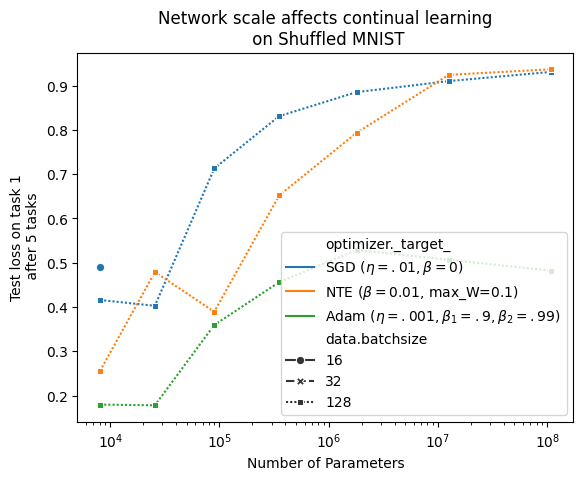

In [85]:

filter_ = np.isnan(runs_df['optimizer.epsilon']) & (runs_df['ntasks']==5)  & (runs_df['ntasks']==5)  * (runs_df['optimizer.momentum'] != 0.9)

g=sns.lineplot(data=runs_df[filter_], x='num_params',y='test metrics.accuracy_0',hue='optimizer._target_', markers=True, style='data.batchsize')
plt.xscale('log')
plt.xlabel('Number of Parameters')
plt.ylabel('Test loss on task 1\n after 5 tasks')
plt.title("Network scale affects continual learning\n on Shuffled MNIST")
new_labels ={'sgd':r"SGD ($\eta=.01, \beta=0$)",
              'nte': r"NTE ($\beta=0.01$, max_W=0.1)", 
              'adam':r'Adam ($\eta=.001, \beta_1=.9, \beta_2=.99$)'}

g.legend()
for t in g.legend_.texts:
#     t.set_text(l)
    if 'sgd' in t.get_text():
        t.set_text(new_labels['sgd'])
    elif 'ens' in t.get_text():
        t.set_text(new_labels['nte'])
    elif 'adam' in t.get_text():
        t.set_text(new_labels['adam'])

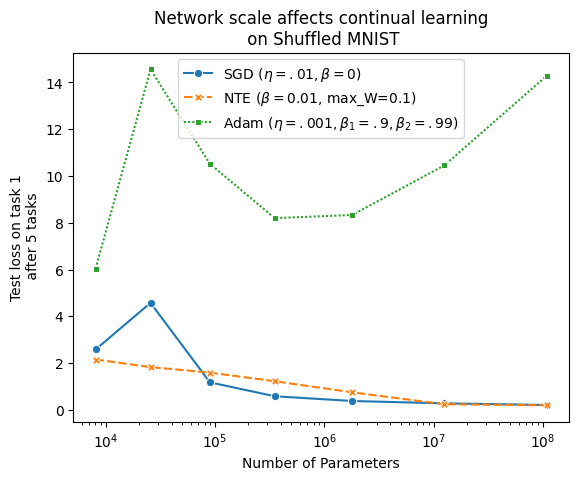

In [80]:

filter_ = np.isnan(runs_df['optimizer.epsilon']) & (runs_df['ntasks']==5)  & (runs_df['ntasks']==5)  * (runs_df['optimizer.momentum'] != 0.9)

g=sns.lineplot(data=runs_df[filter_], x='num_params',y='test metrics.loss_0',hue='optimizer._target_', markers=True, style='optimizer._target_')
plt.xscale('log')
plt.xlabel('Number of Parameters')
plt.ylabel('Test loss on task 1\n after 5 tasks')
plt.title("Network scale affects continual learning\n on Shuffled MNIST")
new_labels ={'sgd':r"SGD ($\eta=.01, \beta=0$)",
              'nte': r"NTE ($\beta=0.01$, max_W=0.1)", 
              'adam':r'Adam ($\eta=.001, \beta_1=.9, \beta_2=.99$)'}

g.legend()
for t in g.legend_.texts:
#     t.set_text(l)
    if 'sgd' in t.get_text():
        t.set_text(new_labels['sgd'])
    elif 'ens' in t.get_text():
        t.set_text(new_labels['nte'])
    elif 'adam' in t.get_text():
        t.set_text(new_labels['adam'])

## The adaptive temperature experiment failed

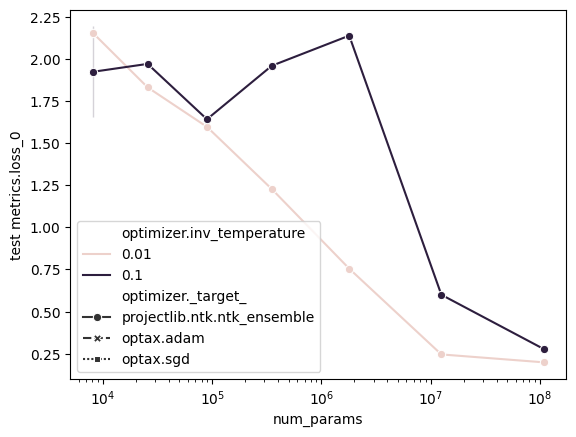

In [22]:
sns.lineplot(data=runs_df, x='num_params',y='test metrics.loss_0',hue='optimizer.inv_temperature', markers=True, style='optimizer._target_')
plt.xscale('log')
